## 1.1 Setting up the dependencies

In [1]:
import time
import uuid #---> Used for getting specific uniform identifier
import os
import cv2

In [2]:
images_path = os.path.join('data','images')
number_images= 0

In [3]:
cap = cv2.VideoCapture(0)

for imagnum in range(number_images):
    print('collecting image {}'.format(imagnum))
    ret,frame = cap.read()
    imgname = os.path.join(images_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname,frame)
    cv2.imshow('frame',frame)
    time.sleep(0.5)

    
    if cv2.waitKey(1) & 0xFF == ord('q')    :
        break
cap.release()
cv2.destroyAllWindows()

## !.2 Annotate Images with Labels

In [4]:
!labelme


# 2. Review Dataset and Build Image Loading Function

In [5]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt


In [6]:
# For avoiding OOM errors by setting GPU Memory Consumption Growt
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu,True)

In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Metal device set to: Apple M1 Pro


True

In [8]:
images = tf.data.Dataset.list_files('data/images/*.jpg',shuffle=False)

In [9]:
images.as_numpy_iterator().next()

b'data/images/d4755528-1330-11ee-9b6c-da95c3cef8a9.jpg'

In [10]:
def load_image(x):
    byt_imag = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byt_imag)
    return img

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

## View Raw images as with matpllotlib

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

In [18]:
plot_images = image_generator.next()

StopIteration: 

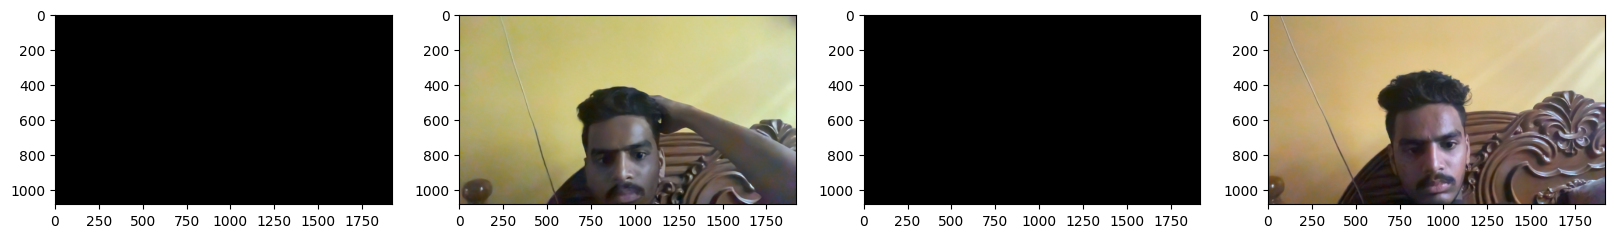

In [19]:
img,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition of Unaugumented Data

## 3.1 Manually split data into train val and test

In [20]:
126*0.7 # train 88

88.19999999999999

In [21]:
126*.15 # test - 19

18.9

In [22]:
# val 19

## 3.2 Move the matching labels

In [23]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath,new_filepath)
            

# 4. Apply image Augumentaions on the images using the Albumentaions

## 4.1 Setup Albumentations Transform Pipeline

In [24]:
import albumentations as alb

In [25]:
augumentor = alb.Compose([alb.RandomCrop(width=(450),height = 450),alb.HorizontalFlip (p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),alb.VerticalFlip(p=0.2)],
                         bbox_params = alb.BboxParams(format='albumentations',
                                                     label_fields=['class_labels']))

## 4.2 Load a Test image and Annotation with opencv and json

In [26]:
img = cv2.imread(os.path.join('data','train','images','17c3c022-11e6-11ee-9bb4-da95c3cef8a9.jpg'))

In [27]:
img

array([[[213, 232, 239],
        [215, 234, 241],
        [217, 236, 243],
        ...,
        [153, 187, 203],
        [134, 168, 184],
        [116, 150, 166]],

       [[216, 235, 242],
        [217, 236, 243],
        [218, 237, 244],
        ...,
        [152, 186, 202],
        [138, 172, 188],
        [124, 158, 174]],

       [[219, 238, 245],
        [219, 238, 245],
        [220, 239, 246],
        ...,
        [157, 191, 207],
        [150, 184, 200],
        [143, 177, 193]],

       ...,

       [[188, 207, 222],
        [188, 207, 222],
        [188, 207, 222],
        ...,
        [152, 174, 192],
        [146, 168, 186],
        [147, 169, 187]],

       [[183, 202, 217],
        [185, 204, 219],
        [187, 206, 221],
        ...,
        [148, 170, 188],
        [141, 163, 181],
        [143, 165, 183]],

       [[177, 196, 211],
        [181, 200, 215],
        [186, 205, 220],
        ...,
        [149, 171, 189],
        [146, 168, 186],
        [153, 175, 193]]

In [28]:
with open(os.path.join('data','train','labels','195aa540-11e6-11ee-9bb4-da95c3cef8a9.json'),'r') as f :
    label = json.load(f)

In [29]:
(label['shapes'][0]['label'])

'face'

## 4.3 Extract coordinates and rescale to match image resolution

In [30]:
coords = [0,0,0,0]

In [31]:
coords[0]= label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] =label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [32]:
coords ## ----> (x1,y1(Top coordinates),x2,y2(Bottom Cooordinates))

[726.3934426229508, 323.60655737704917, 1247.704918032787, 887.5409836065573]

In [33]:
x = cv2.imread('data/train/images/149364c0-11e6-11ee-9bb4-da95c3cef8a9.jpg') ## to check the shape of the images

In [34]:
x.shape

(1080, 1920, 3)

In [35]:
coords = list(np.divide(coords,[1920,1080,1920,1080])) ## _---> Dividing the image with the height of image and width of image 
# My webcam resolution is different so i am using the values 

In [36]:
coords

[0.37832991803278687,
 0.2996357012750455,
 0.6498463114754098,
 0.8217972070431087]

## 4.4 Apply Augumentations and view results

In [37]:
augumented = augumentor(image = img,bboxes =[coords],class_labels = ['face'])

In [38]:
augumented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [39]:
(augumented['bboxes'][0])

(0.0, 0.0, 0.006010928961748808, 0.6386520947176685)

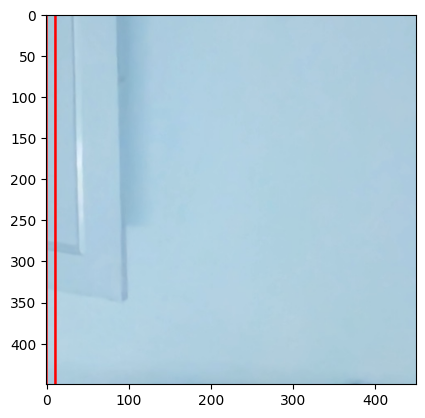

In [40]:
cv2.rectangle(augumented['image'],
              tuple(np.multiply(augumented['bboxes'][0][:2], [1920, 1080]).astype(int)),
              tuple(np.multiply(augumented['bboxes'][0][2:], [1920, 1080]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augumented['image'])


# 5. Build and Run Augumentation Pieline

In [41]:
## 5.1 Run Augumentation Pipeline

In [42]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augumented = augumentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.png'), augumented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augumented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augumented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
image must be numpy array type
image must be numpy array type
image must be numpy array type


In [43]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.png', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [44]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.png', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [45]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.png', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [46]:
train_images.as_numpy_iterator().next()

array([[[0.24319853, 0.20643382, 0.1711397 ],
        [0.22585784, 0.18664216, 0.14742647],
        [0.20214461, 0.16421568, 0.12892157],
        ...,
        [0.50030637, 0.50030637, 0.49246323],
        [0.4295956 , 0.4295956 , 0.4266544 ],
        [0.502451  , 0.502451  , 0.502451  ]],

       [[0.21397059, 0.1747549 , 0.13897058],
        [0.1956495 , 0.15643382, 0.11721814],
        [0.30324754, 0.2680147 , 0.23259804],
        ...,
        [0.5172181 , 0.5206495 , 0.5025123 ],
        [0.41764706, 0.41764706, 0.40980393],
        [0.53204656, 0.53204656, 0.53204656]],

       [[0.2518995 , 0.21268383, 0.17346814],
        [0.47414216, 0.44276962, 0.39963236],
        [0.46550244, 0.4341299 , 0.39099264],
        ...,
        [0.52794117, 0.53137255, 0.5132353 ],
        [0.40931374, 0.40931374, 0.4014706 ],
        [0.44344363, 0.4356005 , 0.43952206]],

       ...,

       [[0.3995711 , 0.34920344, 0.32567403],
        [0.45490196, 0.41188726, 0.38829657],
        [0.45447305, 0

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [47]:
def load_labels (label_path):
    with open(label_path.numpy(),'r',encoding='utf-8') as f:
        label = json.load(f)
    return [label['class'], label['bbox']]

In [48]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json',shuffle=False)

In [49]:
train_labels.as_numpy_iterator().next()

b'aug_data/train/labels/12c92cf6-11eb-11ee-bd2f-da95c3cef8a9.0.json'

In [50]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [51]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [52]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
train_labels.as_numpy_iterator().next()

(0, array([0., 0., 0., 0.], dtype=float16))

# 7. Combine Labels and Image Samples

## 7.1 Create partitions

In [54]:
len(train_images),len(train_labels),len(test_images),len(test_labels),len(val_images),len(val_labels)

(5280, 5280, 1140, 1140, 1140, 1140)

## 7.2 create final dataset

In [55]:
train = tf.data.Dataset.zip(train_images,train_labels)
train = train.shuffle(6000)
train = train.batch(8)
train = train.prefetch(4)

In [56]:
test = tf.data.Dataset.zip(test_images,test_labels)
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [57]:
val = tf.data.Dataset.zip(val_images,val_labels)
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [58]:
train.as_numpy_iterator().next()[1]

(array([1, 0, 0, 1, 1, 1, 0, 1], dtype=uint8),
 array([[0.06757, 0.314  , 1.     , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 1.     , 1.     ],
        [0.507  , 0.3757 , 1.     , 1.     ],
        [0.     , 0.09125, 0.7715 , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.806  , 1.     ]], dtype=float16))

## 7.3 View Images and Annotations

In [59]:
data_samples = train.as_numpy_iterator()

In [60]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


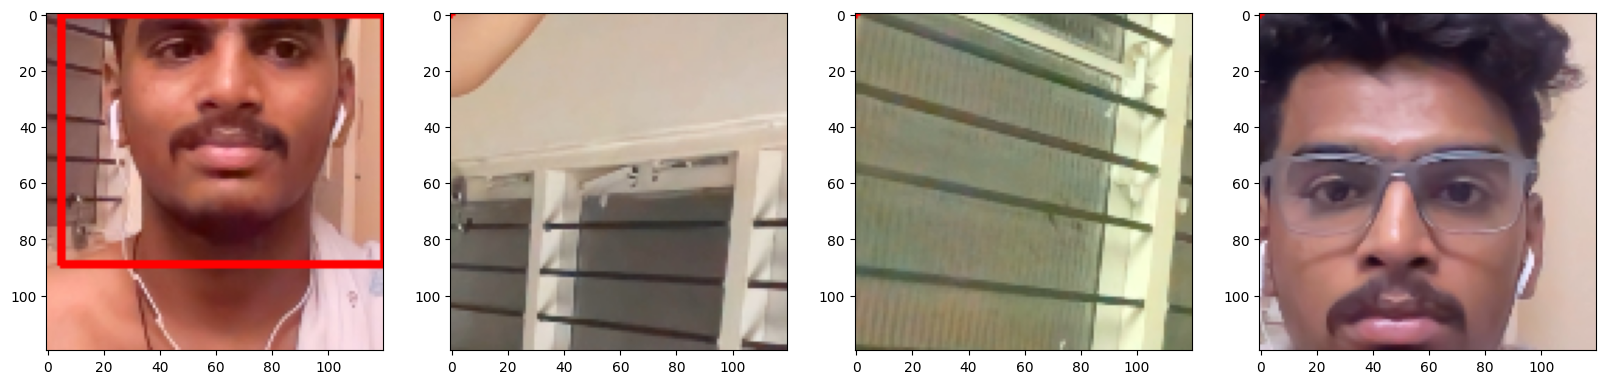

In [61]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Building the Deep Learning Model

## 8.1 Import Layers and base Network

In [62]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Input,MaxPooling2D,Dense,GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG

In [63]:
vgg = VGG16(include_top=False)

In [64]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build instance of Network

In [65]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)
    
    #Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048,activation = 'relu')(f1)
    class2 = Dense(1,activation = 'sigmoid')(class1)
    
    
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048,activation='relu')(f2)
    regress2 = Dense(1,activation='sigmoid')(regress1)
    facetracker = Model(inputs = input_layer,outputs = [class2,regress2])
    return facetracker

In [66]:
facetracker = build_model()

In [67]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [68]:
X,y = train.as_numpy_iterator().next()

In [69]:
X

array([[[[0.23921569, 0.19215687, 0.14509805],
         [0.27677697, 0.21697304, 0.16599265],
         [0.374326  , 0.2998162 , 0.23756127],
         ...,
         [0.46078432, 0.42371324, 0.3702206 ],
         [0.4642157 , 0.425     , 0.3779412 ],
         [0.4627451 , 0.42352942, 0.37941176]],

        [[0.2372549 , 0.19803922, 0.15784314],
         [0.29558823, 0.2348652 , 0.18431373],
         [0.40980393, 0.32696077, 0.25140932],
         ...,
         [0.46360293, 0.42536765, 0.3778186 ],
         [0.46268383, 0.43131128, 0.3803309 ],
         [0.45471814, 0.4233456 , 0.3723652 ]],

        [[0.25876224, 0.20784314, 0.16207108],
         [0.33529413, 0.2647059 , 0.20588236],
         [0.4401348 , 0.35085785, 0.28094363],
         ...,
         [0.47218138, 0.44080883, 0.39767158],
         [0.45373774, 0.4223652 , 0.37922794],
         [0.41991422, 0.38069853, 0.3336397 ]],

        ...,

        [[0.8104779 , 0.79479164, 0.78302693],
         [0.80784315, 0.7921569 , 0.78039217]

In [70]:
y

(array([0, 1, 0, 0, 1, 0, 1, 1], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.3599 , 0.3198 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1283 , 0.109  , 1.     , 1.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.9004 , 0.11426, 1.     , 1.     ],
        [0.     , 0.     , 0.3289 , 0.617  ]], dtype=float16))

In [71]:
X.shape

(8, 120, 120, 3)

In [72]:
classes,coords = facetracker.predict(X)

1/1 [==============================] - 0s 230ms/step


In [73]:
classes,coords

(array([[0.3604076 ],
        [0.5007598 ],
        [0.4710188 ],
        [0.44106305],
        [0.37732896],
        [0.5101994 ],
        [0.56145746],
        [0.43915322]], dtype=float32),
 array([[0.33621216],
        [0.43887228],
        [0.46417204],
        [0.4726198 ],
        [0.48947233],
        [0.53282255],
        [0.47633445],
        [0.49778163]], dtype=float32))

# 9. Define Losses and Optimizers

## 9.1 Define Optimizer and LR

In [74]:
len(train)

660

In [75]:
batches_per_epoch = len(train)
lr_decay = (1.0/0.75 - 1)/batches_per_epoch
lr_decay

0.0005050505050505049

In [76]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,decay = lr_decay)

In [77]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [78]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Tesstout Loss Metrics

In [83]:
ytrue = y[1]
yhat = coords
yhat_reshaped = tf.reshape(yhat,(-1,8))
loss = localization_loss(ytrue,yhat_reshaped).numpy()
loss

5.010776

In [85]:
class_loss(y[0],classes).numpy()

0.70509374

# 10. Train Neural Network